# Hyperalignment Tutorial

This jupyter notebook is an example to use searchlight hyperalignment (Guntupalli et al., 2016) on fMRI movie data and benchmark its performance.

In this example, we will use some minimal data from the Guntupalli et al. (2016) paper to save computation time.  This minimal dataset contains 3 subjects, 2 movie runs per subject, and left hemisphere data only.  The data have been preprocessed with motion correction, surface-based alignment, and denoising.

## 0. Preparations

We will use the docker image from https://github.com/Summer-MIND/mind-tools

Reopen the container by typing
```
docker start MIND && docker attach MIND
```
in the command line. (Or
```
docker run -it -p 9999:9999 --name MIND -v ~/Desktop:/mnt ejolly/mind-tools
```
if you haven't used it before).

Then, within the docker container, let's create the directory and download the tutorial data.
```
mkdir /mnt/hyperalignment
cd /mnt/hyperalignment
wget http://discovery.dartmouth.edu/~fma/hyper_data.tar.gz
wget http://discovery.dartmouth.edu/~fma/hyperalignment_tutorial.ipynb
tar xzvf hyper_data.tar.gz
```

Finally, prepare the python packages we will use. Here we will use python2 because PyMVPA dependency h5py is not compatible with python3.
```
source activate py27
pip install h5py nibabel pprocess pymvpa2
```

After all these, you can start a jupyter notebook using
```
jupyter notebook --port=9999 --no-browser --ip=0.0.0.0 --allow-root
```
And copy the url from the terminal to your web browser.

## 1. Import python functions and classes

In [1]:
%matplotlib inline
import numpy as np
from scipy.spatial.distance import pdist, cdist
from mvpa2.datasets.base import Dataset
from mvpa2.mappers.zscore import zscore
from mvpa2.misc.surfing.queryengine import SurfaceQueryEngine
from mvpa2.algorithms.searchlight_hyperalignment import SearchlightHyperalignment
from mvpa2.base.hdf5 import h5save, h5load
# Alternatively, all those above can be imported using
# from mvpa2.suite import *
import matplotlib.pyplot as plt
from mvpa2.support.nibabel.surf import read as read_surface

## 2. Read data
The data are read from numpy npy files and wrapped as Datasets. Features (vertices) are normalized to have unit variance.

In [2]:
dss_train = []
dss_test = []
subjects = ['rid000005', 'rid000011', 'rid000014']

for subj in subjects:
    ds = Dataset(np.load('raiders/{subj}_run00_lh.npy'.format(subj=subj)))
    ds.fa['node_indices'] = np.arange(ds.shape[1], dtype=int)
    zscore(ds, chunks_attr=None)
    dss_train.append(ds)
    ds = Dataset(np.load('raiders/{subj}_run01_lh.npy'.format(subj=subj)))
    ds.fa['node_indices'] = np.arange(ds.shape[1], dtype=int)
    zscore(ds, chunks_attr=None)
    dss_test.append(ds)

In [3]:
# Each run has 336 time points and 10242 features per subject.
print(dss_train[0].shape)
print(dss_test[0].shape)

(336, 10242)
(336, 10242)


## 3. Create SearchlightHyperalignment instance

The QueryEngine is used to find voxel/vertices within a searchlight. This SurfaceQueryEngine use a searchlight radius of 5 mm based on the fsaverage surface.

In [4]:
sl_radius = 5.0
qe = SurfaceQueryEngine(read_surface('fsaverage.lh.surf.gii'), radius=sl_radius)

/opt/conda/envs/py27/lib/python2.7/site-packages/mvpa2/support/nibabel/surf_gifti.py:50: DeprecationWarning: giftiio.read function deprecated. Use nibabel.load() instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  g = giftiio.read(fn)
/opt/conda/envs/py27/lib/python2.7/site-packages/mvpa2/support/nibabel/surf_gifti.py:24: DeprecationWarning: getArraysFromIntent method deprecated. Use get_arrays_from_intent instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  ar = g.getArraysFromIntent(intent)


In [5]:
hyper = SearchlightHyperalignment(
    queryengine=qe,
    compute_recon=False, # We don't need to project back from common space to subject space
    nproc=1, # Number of processes to use. Change "Docker - Preferences - Advanced - CPUs" accordingly.
)

## 4. Create common template space with training data
This step may take a long time.  In my case it's 10 minutes with `nproc=1`.

In [6]:
# mappers = hyper(dss_train)
# h5save('mappers.hdf5.gz', mappers, compression=9)

mappers = h5load('mappers.hdf5.gz') # load pre-computed mappers

## 5. Project testing data to the common space

In [7]:
dss_aligned = [mapper.forward(ds) for ds, mapper in zip(dss_test, mappers)]
_ = [zscore(ds, chunks_attr=None) for ds in dss_aligned]

## 6. Benchmark inter-subject correlations

In [8]:
def compute_average_similarity(dss, metric='correlation'):
    """
    Returns
    =======
    sim : ndarray
        A 1-D array with n_features elements, each element is the average
        pairwise correlation similarity on the corresponding feature.
    """
    n_features = dss[0].shape[1]
    sim = np.zeros((n_features, ))
    for i in range(n_features):
        data = np.array([ds.samples[:, i] for ds in dss])
        dist = pdist(data, metric)
        sim[i] = 1 - dist.mean()
    return sim

In [9]:
sim_test = compute_average_similarity(dss_test)
sim_aligned = compute_average_similarity(dss_aligned)

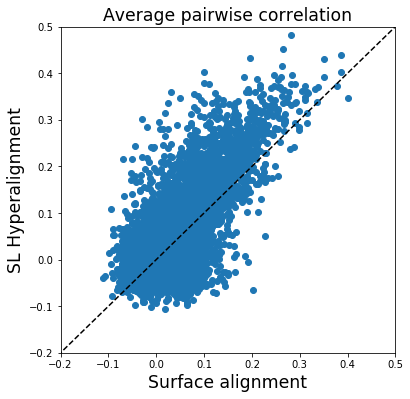

In [10]:
plt.figure(figsize=(6, 6))
plt.scatter(sim_test, sim_aligned)
plt.xlim([-.2, .5])
plt.ylim([-.2, .5])
plt.xlabel('Surface alignment', size='xx-large')
plt.ylabel('SL Hyperalignment', size='xx-large')
plt.title('Average pairwise correlation', size='xx-large')
plt.plot([-1, 1], [-1, 1], 'k--')
plt.show()

## 7. Benchmark movie segment classifications

In [11]:
def movie_segment_classification_no_overlap(dss, window_size=6, dist_metric='correlation'):
    """
    Parameters
    ==========
    dss : list of ndarray or Datasets
    window_size : int, optional
    dist_metric : str, optional

    Returns
    =======
    cv_results : ndarray
        An n_subjects x n_segments boolean array, 1 means correct classification.
    """
    dss = [ds.samples if hasattr(ds, 'samples') else ds for ds in dss]
    def flattern_movie_segment(ds, window_size=6):
        n_seg = ds.shape[0] // window_size
        ds = ds[:n_seg*window_size, :].reshape((n_seg, window_size, -1))
        ds = ds.reshape((n_seg, -1))
        return ds
    dss = [flattern_movie_segment(ds, window_size=window_size) for ds in dss]
    n_subj, n_seg = len(dss), dss[0].shape[0]
    ds_sum = np.sum(dss, axis=0)
    cv_results = np.zeros((n_subj, n_seg), dtype=bool)
    for i, ds in enumerate(dss):
        dist = cdist(ds, (ds_sum - ds) / float(n_subj - 1), dist_metric)
        predicted = np.argmin(dist, axis=1)
        acc = (predicted == np.arange(n_seg))
        cv_results[i, :] = acc
    return cv_results

In [12]:
acc_test = movie_segment_classification_no_overlap(dss_test)
acc_aligned = movie_segment_classification_no_overlap(dss_aligned)
print('Classification accuracy with surface alignment: %.1f%%' % (acc_test.mean()*100, ))
print('Classification accuracy with SL hyperalignment: %.1f%%' % (acc_aligned.mean()*100, ))

Classification accuracy with surface alignment: 59.5%
Classification accuracy with SL hyperalignment: 69.6%


In [13]:
print('Classification accuracy with surface alignment per subject:', acc_test.mean(axis=1))
print('Classification accuracy with SL hyperalignment per subject:', acc_aligned.mean(axis=1))

('Classification accuracy with surface alignment per subject:', array([ 0.5       ,  0.60714286,  0.67857143]))
('Classification accuracy with SL hyperalignment per subject:', array([ 0.64285714,  0.66071429,  0.78571429]))


## Extras

If you have completed all the practices above and want to try more, here are some possible options:

### 1

Try to apply this method to your own surface data.  For example, you can create a common template space with movie data and project retinotopic data to the common space.  Gifti files can be loaded using `mvpa2.datasets.gifti.gifti_dataset`.

### 2

Try to use ROI hyperalignment (`mvpa2.algorithms.hyperalignment.Hyperalignment`) instead of searchlight hyperalignment, and compare computation time and results.

### 3

Read (and practice) more with the more content-rich hyperalignment tutorial http://nbviewer.jupyter.org/url/www.pymvpa.org/notebooks/hyperalignment.ipynb

Data can be downloaded from http://data.pymvpa.org/datasets/hyperalignment_tutorial_data/hyperalignment_tutorial_data.hdf5.gz
